<a href="https://colab.research.google.com/github/Jorayala/AI_Machine_Learning_2024/blob/main/LaboratorioRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio Redes Recurrentes

# 1. Introducción y contexto

La generación de energía fotovoltaica está vinculada con las condiciones climáticas, especialmente a factores como la radiación solar y la temperatura. Estos elementos fluctúan constantemente, lo que presenta desafíos significativos para las compañías eléctricas en la gestión eficiente de la producción y el consumo de electricidad a través de sistemas fotovoltaicos. Para abordar esta problemática, es fundamental realizar pronósticos sobre la potencia de los sistemas solares, siendo la predicción de la irradiación solar un paso crucial en este proceso.

En este laboratorio, exploraremos el uso de Redes Neuronales Recurrentes (RNN), en particular la arquitectura Long Short-Term Memory (LSTM). Estas redes se usaran para mejorar la precisión en la predicción de la Radiación Solar Global Horizontal (GHI). Para nuestro desafio contamos con datos *in situ* proporcionados por el Instituto de Hidrología, Meteorología y Estudios Ambientales de Colombia (IDEAM).

Las RNN son especialmente aptas para modelar secuencias temporales, lo que las convierte en una herramienta valiosa para abordar la naturaleza dinámica de la radiación solar. El amplio uso de las RNN puede explicarse por la mejora de la capacidad de cálculo, la gran disponibilidad de almacenamiento y la mejora de la precisión conseguida. Una proporción significativa de los métodos empleados en la previsión meteorológica se basa en redes neuronales de tipo recurrente, subrayando su eficacia y relevancia en este ámbito


## 1.1. Datos de Radiación Solar Global Horizontal

GHI (Global Horizontal Irradiance) es una medida que describe la cantidad total de radiación solar directa e indirecta recibida por una superficie horizontal. En el contexto de la generación de energía solar, la GHI representa la potencia solar incidente en un plano horizontal, sin tener en cuenta la orientación o inclinación de la superficie receptora. La GHI se expresa típicamente en unidades de potencia por unidad de área, como vatios por metro cuadrado (W/m²).

Los datos de GHI disponibles se han obtenido mediante estaciones meteorológicas ubicadas estratégicamente en la región de estudio. Estas estaciones, operadas por el IDEAM, registran mediciones continuas de GHI, capturando la variabilidad de la medida a lo largo del tiempo. Para nuestro laboratorio contamos con datos para 3 años, con medidas de GHI estimadas cada hora, es decir se cuenta con 26280 observaciones.


## 1.2. Arquitectura Long Short-Term Memory (LSTM)

Las redes LSTM son un tipo especial de RNN capaz de aprender dependencias tanto a corto como largo plazo. Esta capacidad se logra gracias a una celda de memoria que almacena información previa, denominada "cell state". Además, en las LSTM se cuenta con compuertas que les permiten recordar y seleccionar información relevante. A continuación, resumimos las tres compuertas fundamentales:

- *Forget Gate*: Decide qué información pasada debe ser olvidada, adaptándose a las condiciones actuales.

- *Update/Input Gate*: Evalúa la importancia de la información actual y actualiza la memoria en consecuencia.

- *Output Gate*: Decide qué información es crucial para el resultado final y futuras predicciones.

![image.png](imagenLSTM.png)

# 2. Importar y acondicionar datos

In [1]:
# Celda con la importación de librerias

import pandas as pd               # Librería para manejo de dataframes
import numpy as np                # Librería para trabajar don datos matriciales
import matplotlib.pyplot as plt   # Librería de visualización


# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed    # Importar las capas densas y LSTM
from tensorflow.keras.models import Sequential         # Importar modelo de clase secuencial
from tensorflow.keras.callbacks import EarlyStopping   # Importar clase de parada temparana

# Sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score   # Importar métricas de validación
from sklearn.preprocessing import StandardScaler      # Importar objeto para realizar estandarización de variables


from time import time   # Librería para cálculos de tiempos de ejecución


np.random.seed(42) # Inicializar semilla para numeros aleatorios

tf.random.set_seed(42) # Establecer la semilla para el generador de números aleatorios de TensorFlow

In [4]:
# Se lee el archivo de datos y se convierte en un DataFrame,
# una estructura especial que representa los datos en forma de tabla,
# facilitando su manipulación y análisis.

GHI = pd.read_csv('/content/drive/MyDrive/Redes_Neuronales/GHI_sa.csv')
GHI.info()
GHI.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175200 entries, 0 to 175199
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       175200 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


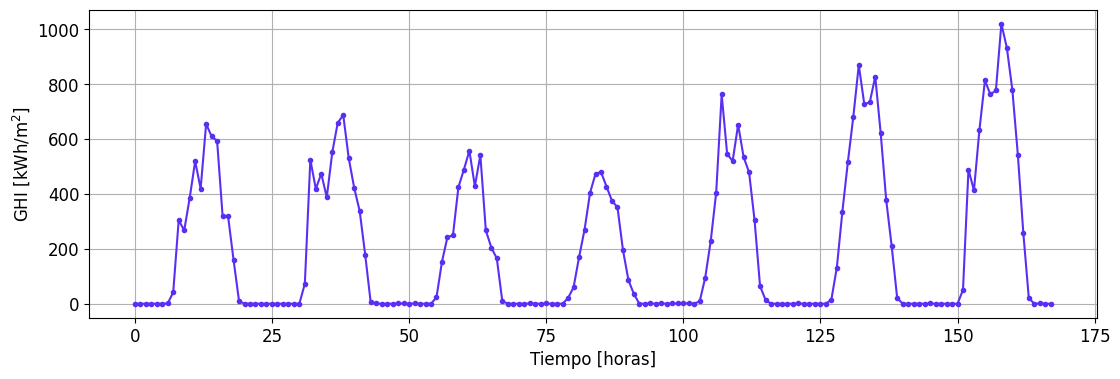

In [5]:
# Una ventana de observación de una semana
# se utiliza para visualizar las señales de GHI.

plt.figure(figsize = (13, 4))
plt.plot(GHI[0:24*7],'#5a2ff4', marker = ".", linewidth= 1.5)
plt.xlabel("Tiempo [horas]", fontsize=12)
plt.xticks(size=12)
plt.ylabel("GHI [kWh/m$^2$]", fontsize=12)
plt.yticks(size=12)
plt.grid()
plt.show()

A continuación, realizamos dos pasos importantes en la preparación de datos para un modelo de predicción de series temporales. Primero, llevamos a cabo la estandarización de la variable de interés, en este caso, la GHI. Luego, procedemos a dividir los datos temporalmente, asignando un año para entrenamiento, otro para pruebas y un tercero para validación. La estandarización es un proceso fundamental que asegura que todas las observaciones compartan una escala común, lo cual es esencial para el buen rendimiento de muchos algoritmos de aprendizaje automático. Aquí, la función StandardScaler transforma los valores de GHI, ajustando la media a cero y la desviación estándar a uno. La segunda parte se encarga de dividir la serie temporal estandarizada en tres conjuntos distintos. El primer año se asigna para entrenamiento (X_train), el segundo para validación (X_val), y el tercer año para pruebas (X_test). Esta división es necesaria para evaluar la capacidad predictiva del modelo en datos no vistos, garantizando una evaluación justa de su rendimiento.

In [6]:
# Estandarización
X = np.array(GHI)       # Arrego de secuencia
scaler = StandardScaler().fit(X.reshape(-1, 1)) # Estandarización de la secuencia
X = scaler.transform(X.reshape(-1, 1)) # Tranformar los datos de la secuencia
X = X.ravel() # Adaptar las dimensiones del arreglo X

# División en conjunto de entrenamiento, validación y prueba
n = 365*24            # Número de horas en un año
X_train = X[:n]       # Separación 1 año de entrenamiento
X_val = X[n:2*n]      # Separación 2 año para validación
X_test = X[2*n:3*n]   # Separación 3 año para prueba

In [7]:
# Imprimimos las dimensiones de los conjuntos
print(f"Dimensión del conjunto general de observaciones {X.shape}")
print(f"Dimensión del conjunto de entrenamiento {X_train.shape}")
print(f"Dimensión del conjunto de validación {X_val.shape}")
print(f"Dimensión del conjunto de prueba {X_test.shape}")

Dimensión del conjunto general de observaciones (175200,)
Dimensión del conjunto de entrenamiento (8760,)
Dimensión del conjunto de validación (8760,)
Dimensión del conjunto de prueba (8760,)


En esta celda de código, presentamos la función `split_sequence`, diseñada para realizar la división de secuencias temporales. La función tiene como objetivo preparar los datos para entrenar modelos predictivos, dividiendo una secuencia temporal en fragmentos más pequeños. Esto facilita al modelo aprender patrones a partir de un histórico distribuido en ventanas de tiempo. Esta función se empleará más adelante para separar los datos de acuerdo con las ventanas sobre las que se desee generar predicciones.

In [8]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    """
    Función que realiza la división de una secuencia temporal en conjuntos de entrada y salida.

    Parámetros:
    - sequence: Secuencia temporal (iterable, como una lista) de observaciones.
    - n_steps_in: Número de observaciones utilizadas en cada ventana de datos de entrada.
    - n_steps_out: Número de observaciones utilizadas en cada ventana de etiquetas secuenciales.

    Salida:
    - np.array(X): Ventanas de tiempo con datos temporales utilizadas como entrada.
    - np.array(y): Ventanas de tiempo con datos temporales utilizadas como etiquetas secuenciales.
    """

    X, y = list(), list()               # Prepara una lista de X, y
    for i in range(len(sequence)):      # Ciclo iterable en todos los elementos de la secuencia temporal
        end_ix = i + n_steps_in         # Cálculo de indices finales de la ventana de observación X
        out_end_ix = end_ix + n_steps_out   # Cálculo de indices finales de la ventana de observación Y
        if out_end_ix > len(sequence): break # Salir del ciclo si el indice final de ventana Y supera la longitud de la secuencia

        # Segmentar vectores y guardar en X, y
        X.append(sequence[i:end_ix])
        y.append(sequence[end_ix:out_end_ix])

    return np.array(X), np.array(y)

# 3. Forecasting con redes LSTM

En el contexto de nuestro estudio, el *forecasting* implica la utilización de datos históricos para anticipar la GHI en intervalos de 24 horas. En particular, el desafio es predecir la GHI para el día inmediatamente posterior después de analizar una semana completa de datos. Inicialmente usando la función de división de ventanas se construyen los conjuntos de datos y etiquetas, luego se genera el modelo de RNN para realizar la predicción y finalmente con los conjuntos de prueba y validación se realiza la evaluación del modelo.

## 3.1 División en ventanas de tiempo

En esta sección se realiza la división de los datos configurando la ventana de observación y predicción. En este caso la ventana de observación será una semana y en predicción el dia siguiente.

In [9]:
# Elegir número de pasos de entrada y salida
n_steps_in_d = 168      # 7 días previos 7*24
n_steps_out_d = 24      # predecir siguiente día

# Dividir en muestras utilizando la función split_sequence
# Datos de entrenamiento
X_t, y_t = split_sequence(X_train, n_steps_in_d, n_steps_out_d)
# Datos de validación
X_v, y_v = split_sequence(X_val, n_steps_in_d, n_steps_out_d)

# Imprimir las dimensiones de los conjuntos segemnetados en ventanas
print(f"Dimensions de datos de observaciones entrenamiento {X_t.shape}")
print(f"Dimensions de datos de predicciones entrenamiento {y_t.shape}")
print(f"Dimensions de datos de observaciones validación {X_v.shape}")
print(f"Dimensions de datos de predicciones validación {y_v.shape}")

Dimensions de datos de observaciones entrenamiento (8569, 168)
Dimensions de datos de predicciones entrenamiento (8569, 24)
Dimensions de datos de observaciones validación (8569, 168)
Dimensions de datos de predicciones validación (8569, 24)


Como ejemplo visualizaremos de manera una ventana temporal específica junto con su correspondiente etiqueta de predicción.

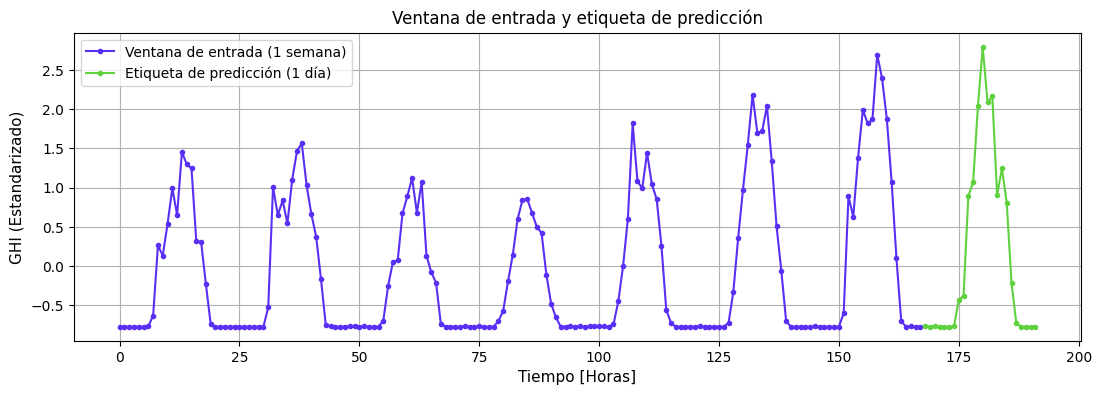

In [10]:
# Tomar una muestra de entrenamiento para la visualización
sample_index = 0  # Indice de la ventana
sample_X, sample_y = X_t[sample_index], y_t[sample_index]

# Crear una figura
plt.figure(figsize=(13, 4))

# Visualizar la ventana de entrada y la etiqueta de predicción
plt.plot(np.arange(len(sample_X)), sample_X, label='Ventana de entrada (1 semana)',
        color = '#5a2ff4', marker = ".", lw= 1.5)
plt.plot(np.arange(len(sample_X), len(sample_X) + len(sample_y)), sample_y, label='Etiqueta de predicción (1 día)',
         color='#60d13e', marker = ".", lw = 1.5)

# Ajustar detalles de la gráfica
plt.title('Ventana de entrada y etiqueta de predicción')
plt.xlabel('Tiempo [Horas]', fontsize=11)
plt.ylabel('GHI (Estandarizado)', fontsize=11)
plt.legend()
plt.grid()

# Mostrar la figura
plt.show()

Antes de continuar con la construcción del modelo LSTM, los datos deben ser acondicionados en el número de caracteristicas. La redimensión de las muestras temporales, originalmente en el formato [muestras, timesteps], se lleva a cabo para incluir una dimensión adicional que representa las características de cada punto temporal. Este ajuste estructural, de [muestras, timesteps] a [muestras, timesteps, características], es esencial para adecuar los datos al formato requerido por muchos modelos de redes neuronales, donde cada paso temporal puede tener múltiples características asociadas. En nuestro caso solamente se tiene una carácteristica, pero el modelo tambíen podría considerar otras variables.

In [11]:
# Redimensionar [muestras, timesteps] a [muestras, timesteps, características]
n_features = 1 # En este caso solo se tiene una característica en cada observación temporal
# Redimensionamiento
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features)) # Ventana de entrada en entrenamiento
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features)) # Ventana de etiquetas en entrenamiento
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features)) # Ventana de entrada en validación
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features)) # Ventana de etiquetas en validación

# Imprimir las dimensiones de los conjuntos redimensionados
print(f"Dimensions de datos de observaciones entrenamiento {X_t.shape}")
print(f"Dimensions de datos de predicciones entrenamiento {y_t.shape}")
print(f"Dimensions de datos de observaciones validación {X_v.shape}")
print(f"Dimensions de datos de predicciones validación {y_v.shape}")

Dimensions de datos de observaciones entrenamiento (8569, 168, 1)
Dimensions de datos de predicciones entrenamiento (8569, 24, 1)
Dimensions de datos de observaciones validación (8569, 168, 1)
Dimensions de datos de predicciones validación (8569, 24, 1)


## 3.2 Modelo LSTM

En esta sección, establecemos la arquitectura de nuestro modelo de *forecasting* diario utilizando una red neuronal recurrente RNN. El diseño consta de un *encoder* seguido por un *decoder*, implementando la arquitectura LSTM (Long Short-Term Memory) para capturar patrones temporales.

- **Encoder:** En la primera etapa, creamos el componente encoder del modelo. Este consiste en una capa LSTM con 5 unidades y una forma de entrada que refleja la ventana de 7 días previos (n_steps_in_d). La capa `RepeatVector` replica el vector de entrada para ajustarse a la longitud de la ventana de salida, establecida en 24 horas (n_steps_out_d).

- **Decoder:** El componente decoder consiste en otra capa LSTM con 5 unidades. La capa `TimeDistributed` junto con una capa densa final, implementa la proyección de las características aprendidas en cada paso temporal a la predicción de la GHI. El modelo se compila utilizando el optimizador 'adam' y la función de pérdida 'mse' (Mean Squared Error).

In [12]:
# Modelo LSTM para predicción

model = Sequential()      # Tipo de modelo secuencial

# Encoder
model.add(LSTM(5, input_shape=(n_steps_in_d, n_features))) # Capa LSTM con 5 unidades y preparada para recibir n_steps_in_d
model.add(RepeatVector(n_steps_out_d)) # Repite el vector de salida tantas veces como indique n_steps_out_d

# Decoder
model.add(LSTM(5, return_sequences=True)) # Capa LSTM con 5 unidades y configurada para devolver secuencias completas
model.add(TimeDistributed(Dense(1)))    # Permite que la capa densa sea aplicada a cada paso temporal de la secuencia por separado.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Resumen de la arquitectural del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5)                   │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 24, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 5)               │             220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 24, 1)               │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366 (1.43 KB)

 Trainable params: 366 (1.43 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compilación del modelo
model.compile(optimizer='adam', loss='mse')

En esta etapa, procedemos con el entrenamiento del modelo de forecasting diario utilizando los conjuntos de datos de entrenamiento y validación. Para el entrenamiento se configuró una estrategia de parada anticipada (`EarlyStopping`) con el objetivo de prevenir el sobreajuste del modelo. Esta estrategia detendrá el entrenamiento si la métrica de validación no mejora después de un cierto número de épocas y restaurará los pesos del modelo a los mejores obtenidos.

In [15]:
# Entrenamiento del modelo
start = time()        # Se fija el tiempo incial en el que esta iniciando el entrenamiento

# Configuración parada temprana, se detiene si no mejora despues de 10 épocas
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Entrenamiento del modelo con 40 epocas, tamaño del lote 128 y estrategia de parada temprana
history = model.fit(X_t, y_t, epochs=20, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])

print("El modelo tardó %.2f segundos en entrenar."% (time() - start)) # Tiempo total del entrenamiento

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 1.0593 - val_loss: 1.0206
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.9967 - val_loss: 0.9212
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.8788 - val_loss: 0.7739
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.7272 - val_loss: 0.5831
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.5514 - val_loss: 0.4811
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.4730 - val_loss: 0.4276
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.4266 - val_loss: 0.3897
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.3903 - val_loss: 0.3587
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.3591 - val_loss: 0.3304
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.3299 - val_loss: 0.3039
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.3021 - val_loss: 0.2754
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - lo

In [16]:
def visualization_history(resultsFit):
    """
    Esta función grafica las curvas de pérdida a lo largo de las épocas de entrenamiento
    para el conjunto de prueba como el de validación.
    Parámetros:
    resultsFit = historial de entrenamiento de un modelo en keras
    Salida:
    Gráfica de la precisión en validación y prueba.
    """
    # Llamado al entrono de la gráfica y fijar tamaño de visualización
    fig, axes = plt.subplots(1, 1, figsize=(13, 4))

    # Graficar la pérdida de la historia en entrenamiento
    axes.plot(range(len(resultsFit.history['loss'])), resultsFit.history['loss'],
           '#5a2ff4', linestyle = "-", marker = ".",
           label='Pérdida entrenamiento', lw = 2)

    # Graficar la presición de la historia en validación
    axes.plot(range(len(resultsFit.history['val_loss'])), resultsFit.history['val_loss'],  '#60d13e',
           label='Pérdida validación', linestyle = '-', marker = '.', lw =2)

    # Títulos de los ejes
    axes.set_xlabel('Época',fontsize=12)
    axes.set_ylabel(r'Pérdida',fontsize=12)
    axes.grid()      # Activar la cuadricula
    axes.legend(fontsize=12,loc = 'upper right')   # Establecer la legenda


    plt.tight_layout() # Ajusta automáticamente el diseño de la figura
    plt.show()

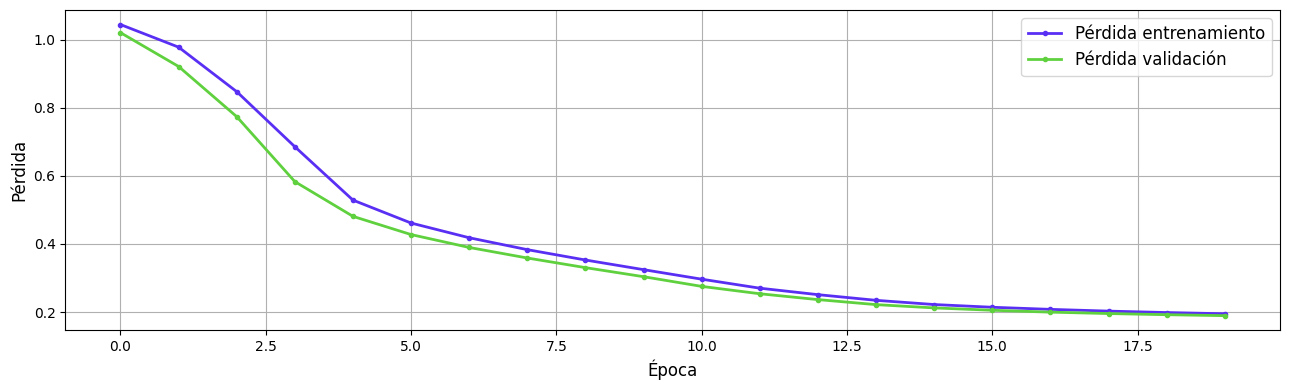

In [17]:
# Llamado a la función de visualización de las métricas de la historia del entrenamiento
# del modelo.
visualization_history(history)

## 3.3. Evaluación del modelo

En esta sección, examinaremos los resultados del entrenamiento llevado a cabo. Se cálcula para la primera ventana del conjunto de prueba las métricas del error cuadrático medio, el error absoluto y el coeficiente $R^2$

In [18]:
# División en ventanas del conjunto de prueba
X_test_, y_test_ = split_sequence(X_test, n_steps_in_d, n_steps_out_d)
# Transfromación inversa de los datos de predicción:
# Aplicamos una transformación inversa a las etiquetas de predicción (y_test)
# utilizando el objeto scaler. Este objeto se utilizó previamente para estandarizar los
# datos durante la preparación. Ahora se invierte para obtener las predicciones en la
# escala original de la GHI.
y_test = scaler.inverse_transform(y_test_)

A continuación se realiza la predicción de GHI en el octavo día  utilizando el modelo que ha sido previamente entrenado.

In [19]:
# Elegir un indice de ventana del conjunto de prueba, puede ser cualquier ventana
window_prediction = 0

# Preparación de la entrada para la predicción
x_input = X_test_[window_prediction].reshape((1, n_steps_in_d, n_features))

# Realización de la predicción y transformación inversa de los datos
yhat_normalized = model.predict(x_input)
yhat_unscaled = scaler.inverse_transform(yhat_normalized.reshape(-1, 1))

# Transformación inversa de los datos originales del conjunto de prueba
original_data_unscaled = scaler.inverse_transform(X_test_[window_prediction].reshape(-1, 1))

# Selección de datos para comparación: actual, predicción y datos previos
actual_data = y_test[0]
previous_data = np.hstack((original_data_unscaled.ravel(), actual_data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


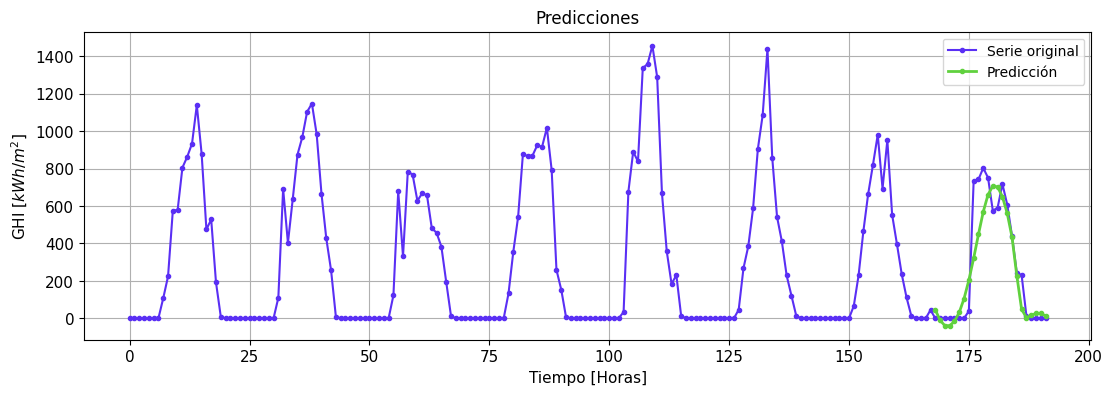

In [20]:
windows_time = np.arange(24*8)

# Crear una figura
plt.figure(figsize=(13, 4))

# Visualizar la ventana de entrada y la etiqueta de predicción
plt.plot(previous_data, label='Serie original',
        color = '#5a2ff4', marker = ".", lw= 1.5)
plt.plot(windows_time[24*7:], yhat_unscaled, label='Predicción',
         color='#60d13e', marker = ".", lw = 2)

# Ajustar detalles de la gráfica
plt.title('Predicciones')
plt.xlabel('Tiempo [Horas]', fontsize=11)
plt.ylabel('GHI $[kWh/m^2]$', fontsize=11)
plt.yticks(size=11)
plt.xticks(size=11)
plt.legend()
plt.grid()

# Mostrar la figura
plt.show()

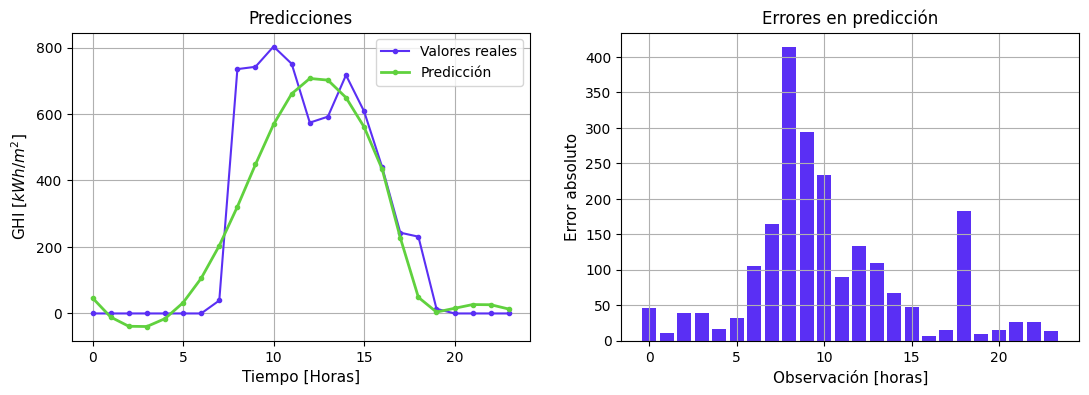

In [21]:
# Crear una figura
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Visualizar la salida del modelo y la etiqueta de predicción
axes[0].plot(actual_data, label='Valores reales',
        color = '#5a2ff4', marker = ".", lw= 1.5)
axes[0].plot(yhat_unscaled, label='Predicción',
         color='#60d13e', marker = ".", lw = 2)

# Ajustar detalles de la gráfica
axes[0].set_title('Predicciones')
axes[0].set_xlabel('Tiempo [Horas]', fontsize=11)
axes[0].set_ylabel('GHI $[kWh/m^2]$', fontsize=11)
axes[0].legend()
axes[0].grid()


# Visualizar la salida del modelo y la etiqueta de predicción
axes[1].bar(range(24), np.abs(actual_data - yhat_unscaled.reshape(24,)),
            color = '#5a2ff4')

# Ajustar detalles de la gráfica
axes[1].set_title('Errores en predicción')
axes[1].set_xlabel('Observación [horas]', fontsize=11)
axes[1].set_ylabel('Error absoluto', fontsize=11)
axes[1].grid()

# Mostrar la figura
plt.show()

Ahora procedemos al cálculo de las métricas de evaluación para esta ventana en particular. En primer lugar, calculamos el error cuadrático medio y el error absoluto, que nos proporcionarán una medida de la precisión de nuestras predicciones. Además, evaluamos el coeficiente de determinación, representado como $R^2$, el cual es una medida estadística que nos indica la proporción de la varianza en la variable dependiente que puede ser predicha por las variables independientes en un modelo de predicción. En líneas generales, cuanto más próximo a 1 sea el valor de $R^2$, mejor será el ajuste del modelo a los datos.

In [22]:
rmse = np.sqrt(mean_squared_error(actual_data, yhat_unscaled))
mae = mean_absolute_error(actual_data, yhat_unscaled)
r2 = r2_score(actual_data, yhat_unscaled)

print(f'Root mean square error: {rmse:0.2f}')
print(f'Mean absolute error: {mae:0.2f}')
print(f'R-Squared: {r2:0.2f}')

Root mean square error: 135.01
Mean absolute error: 89.11
R-Squared: 0.82


**Importante: Para finalizar el laboratorio y verificar que llegaste hasta el final reporta el valor alcanzado por el modelo en el coeficiente R-Squared (variable r2) con la ventana de prueba, usa solo dos decimales. Este valor debe quedar en la variable r2Test, por favor no renombres la variable.**

In [ ]:
r2Test = 0 # Cambia el valor de esta varible reportando solo con dos decimales el valor de R-Squared